📊 RMSE: 12.95
📊 MAE : 10.21


/tmp/ipython-input-1-539550965.py:95: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


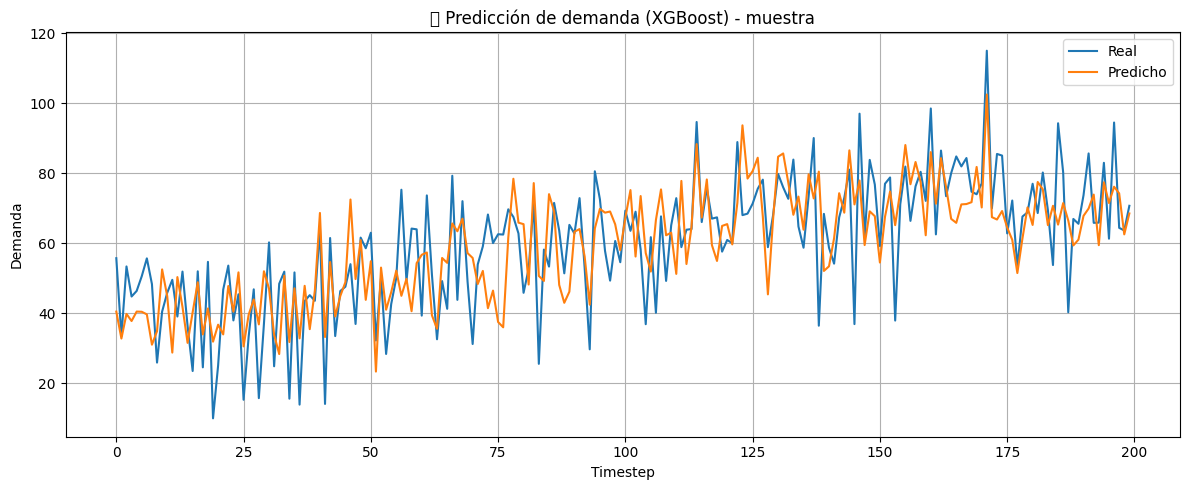

/tmp/ipython-input-1-539550965.py:107: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


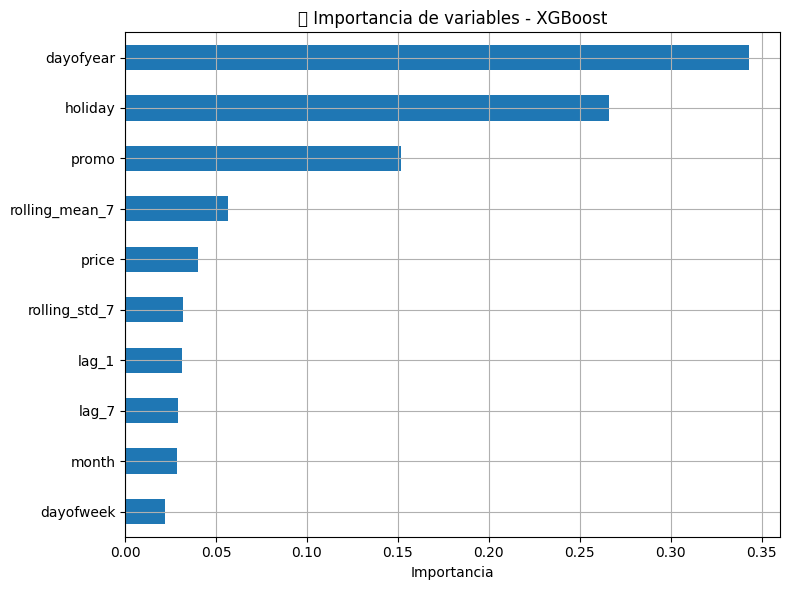

In [1]:
# 📦 Instalación necesaria (si usas Google Colab)
!pip install -q xgboost pandas matplotlib scikit-learn

# ======================
# 📌 IMPORTS
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ======================
# 1️⃣ SIMULACIÓN DE DATOS MULTIVARIADOS
# ======================
np.random.seed(42)
n_days = 365 * 2
dates = pd.date_range(start='2022-01-01', periods=n_days, freq='D')
products = ['Product_A', 'Product_B', 'Product_C']
data = []

for product in products:
    base_demand = 100 + np.random.normal(0, 10, n_days)
    price = np.random.normal(10, 1, n_days)
    promo = np.random.choice([0, 1], size=n_days, p=[0.7, 0.3])
    holiday = np.random.choice([0, 1], size=n_days, p=[0.9, 0.1])
    seasonality = 20 * np.sin(2 * np.pi * np.arange(n_days) / 365)
    noise = np.random.normal(0, 5, n_days)
    demand = base_demand + 10 * promo - 5 * price + 15 * holiday + seasonality + noise

    df = pd.DataFrame({
        'date': dates,
        'product': product,
        'price': price,
        'promo': promo,
        'holiday': holiday,
        'demand': demand
    })
    data.append(df)

df_all = pd.concat(data).reset_index(drop=True)

# ======================
# 2️⃣ CREACIÓN DE FEATURES TEMPORALES
# ======================
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['lag_1'] = df.groupby('product')['demand'].shift(1)
    df['lag_7'] = df.groupby('product')['demand'].shift(7)
    df['rolling_mean_7'] = df.groupby('product')['demand'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df.groupby('product')['demand'].shift(1).rolling(window=7).std()
    return df

df_all = create_features(df_all)
df_all.dropna(inplace=True)

# ======================
# 3️⃣ MODELADO CON XGBOOST
# ======================
features = ['price', 'promo', 'holiday', 'dayofweek', 'month', 'dayofyear',
            'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']

X = df_all[features]
y = df_all['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# ======================
# 4️⃣ EVALUACIÓN
# ======================
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE : {mae:.2f}")

# ======================
# 5️⃣ VISUALIZACIÓN RESULTADOS
# ======================
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label='Real')
plt.plot(y_pred[:200], label='Predicho')
plt.title("📈 Predicción de demanda (XGBoost) - muestra")
plt.xlabel("Timestep")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Importancia de variables
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
feat_importance.plot(kind='barh')
plt.title("🎯 Importancia de variables - XGBoost")
plt.xlabel("Importancia")
plt.grid(True)
plt.tight_layout()
plt.show()


📋 Errores por producto:
     product       RMSE        MAE  Mean Actual  Mean Predicted
0  Product_C  12.952445  10.207971    52.682099       52.355423


/tmp/ipython-input-2-462481864.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_errors = df_all_clean.groupby('product').apply(
/tmp/ipython-input-2-462481864.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


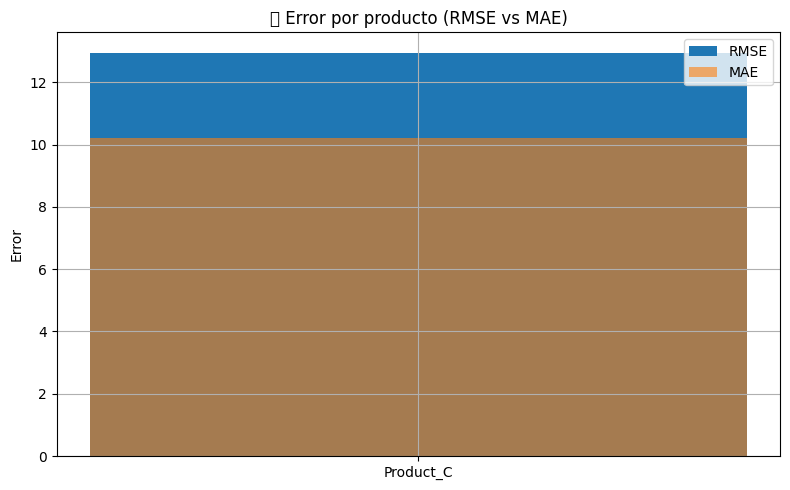

In [2]:
# ================================
# 6️⃣ Análisis de errores por producto
# ================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Añadir predicciones al dataframe
df_all_clean = df_all.iloc[X_train.shape[0]:].copy().reset_index(drop=True)
df_all_clean['y_true'] = y_test.values
df_all_clean['y_pred'] = y_pred

# Calcular métricas por producto
grouped_errors = df_all_clean.groupby('product').apply(
    lambda g: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(g['y_true'], g['y_pred'])),
        'MAE': mean_absolute_error(g['y_true'], g['y_pred']),
        'Mean Actual': g['y_true'].mean(),
        'Mean Predicted': g['y_pred'].mean()
    })
).reset_index()

print("📋 Errores por producto:")
print(grouped_errors)

# Visualizar
plt.figure(figsize=(8, 5))
plt.bar(grouped_errors['product'], grouped_errors['RMSE'], label='RMSE')
plt.bar(grouped_errors['product'], grouped_errors['MAE'], alpha=0.6, label='MAE')
plt.title("🔍 Error por producto (RMSE vs MAE)")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
